##BERT 

In [ ]:
from google.colab import drive
drive.mount("/content/MyDrive")

Mounted at /content/MyDrive


In [ ]:
!pip install ipython-autotime
%load_ext autotime


In [ ]:
######################
## IMPORT LIBRARIES ##
######################


!pip install transformers
import json
import random 
from datetime import datetime 

import matplotlib 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import torch 
from keras.callbacks import EarlyStopping 
from keras.layers import Dense, Dropout 
from keras.models import Sequential 
from keras.optimizers import adagrad_v2
from sklearn.decomposition import PCA 
from sklearn.metrics import classification_report, f1_score 
from sklearn.utils import class_weight 
from tqdm import tqdm 
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification


## Load the data


In [ ]:
train_path = "/content/MyDrive/MyDrive/Data/THESIS DATA/train.json"
val_path = "/content/MyDrive/MyDrive/Data/THESIS DATA/validation.json"
test_path = "/content/MyDrive/MyDrive/Data/THESIS DATA/test.json"
path = "/content/drive/MyDrive/"
device = "cuda"

with open(train_path, "r") as f:
  train = json.load(f)

with open(val_path,"r") as f:
  val = json.load(f)

with open(test_path,"r") as f:
  test = json.load(f)

In [ ]:
model_path = "dbmdz/bert-base-turkish-cased"

tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")

def base_model():
  return AutoModelForSequenceClassification.from_pretrained("dbmdz/bert-base-turkish-cased", num_labels=3).to(device)

base = base_model()

Downloading:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/245k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-base-turkish-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were 

In [ ]:
mapping = {"negative": 0, "neutral":1, "positive":2}

def to_id(text):
  return torch.tensor(tokenizer.encode(text))

def feature_extraction(data, max_seq_lenght=50):
  sentences = [el["sentence"] for el in data]
  y = [mapping[el["value"]] for el in data]
  return tokenizer(sentences, padding="max_length", truncation=True,max_length=max_seq_lenght) ,y 

In [ ]:
class BOUNDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key,val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
categories = [0,1,2]

x_train, y_train = feature_extraction(train)
train_set = BOUNDataset(x_train, y_train)
x, y = feature_extraction(val)
dev_set = BOUNDataset(x,y)
x,y = feature_extraction(test)
test_set = BOUNDataset(x,y)


In [ ]:
#########
## GPU ##
#########
if torch.cuda.is_available():
   device = "cuda:0"
else :
   device = "cpu"

device = torch.device(device)

In [ ]:
###################
## CLASS WEIGHTS ##
###################

from sklearn.utils.class_weight import compute_class_weight

weights = torch.Tensor(compute_class_weight(classes=[0,1,2], y=y_train, class_weight= "balanced")).to(device)

In [ ]:
################
## TRAIN BERT ##
################

from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average = "macro")
  acc = accuracy_score(labels, preds)
  return { 
      "accuracy": acc,
      "f1": f1,
      "precision": precision,
      "recall": recall
  }



from transformers import Trainer, TrainingArguments 

class MultilabelTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False):
    labels = inputs.pop("labels")
    outputs = model(**inputs)
    logits = outputs.logits
    loss_fct = torch.nn.CrossEntropyLoss(weight=weights)
    loss = loss_fct(logits.view(-1, self.model.config.num_labels),
                    labels)
    
    return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(
    output_dir='transformer_results',
    overwrite_output_dir = True,
    num_train_epochs=10,
    per_device_train_batch_size=24,
    gradient_accumulation_steps=1,
    per_device_eval_batch_size=36,
    warmup_steps=300,
    weight_decay=0.1,
    learning_rate=1e-5,
    logging_dir='transformer_logs',
    logging_steps=5,
    load_best_model_at_end=True,
    evaluation_strategy = "steps",
    metric_for_best_model = "recall",
    do_eval=True,
    save_total_limit=1,
    )


trainer = MultilabelTrainer(
     args = training_args, 
      train_dataset=train_set,
      eval_dataset = dev_set, 
      compute_metrics = compute_metrics,
      model_init = base_model 
  )

loading configuration file https://huggingface.co/dbmdz/bert-base-turkish-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/4bcf91c5f5c2b69c278c1fa439966e8f119b238f647a4e7e5b8ac163ecab8f8d.d34b61340faaa3122b620c12ba54ab8b1016bfeb2ff97c1d5e80b86808783b7a
Model config BertConfig {
  "_name_or_path": "dbmdz/bert-base-turkish-cased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.15.0",
  "type_vocab_size": 2,
  "use_cache": 

In [ ]:
trainer.train()

loading configuration file https://huggingface.co/dbmdz/bert-base-turkish-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/4bcf91c5f5c2b69c278c1fa439966e8f119b238f647a4e7e5b8ac163ecab8f8d.d34b61340faaa3122b620c12ba54ab8b1016bfeb2ff97c1d5e80b86808783b7a
Model config BertConfig {
  "_name_or_path": "dbmdz/bert-base-turkish-cased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.15.0",
  "type_vocab_size": 2,
  "use_cache": 

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
5,1.126800,1.117419,0.233177,0.185559,0.337389,0.327210
10,1.081300,1.116579,0.233177,0.185525,0.335999,0.327210
15,1.136900,1.115302,0.231612,0.184439,0.333995,0.324260
20,1.085300,1.114357,0.228482,0.184479,0.343870,0.319147
25,1.109200,1.113114,0.231612,0.189437,0.370077,0.321906
30,1.141800,1.111580,0.231612,0.189482,0.354034,0.321906
35,1.111800,1.109195,0.234742,0.194388,0.375251,0.324665
40,1.096300,1.106403,0.236307,0.197824,0.391877,0.326438
45,1.116100,1.104190,0.241002,0.203104,0.412388,0.336075
50,1.104400,1.101787,0.242567,0.203240,0.401382,0.344916


***** Running Evaluation *****
  Num examples = 639
  Batch size = 36
***** Running Evaluation *****
  Num examples = 639
  Batch size = 36
***** Running Evaluation *****
  Num examples = 639
  Batch size = 36
***** Running Evaluation *****
  Num examples = 639
  Batch size = 36
***** Running Evaluation *****
  Num examples = 639
  Batch size = 36
***** Running Evaluation *****
  Num examples = 639
  Batch size = 36
***** Running Evaluation *****
  Num examples = 639
  Batch size = 36
***** Running Evaluation *****
  Num examples = 639
  Batch size = 36
***** Running Evaluation *****
  Num examples = 639
  Batch size = 36
***** Running Evaluation *****
  Num examples = 639
  Batch size = 36
***** Running Evaluation *****
  Num examples = 639
  Batch size = 36
***** Running Evaluation *****
  Num examples = 639
  Batch size = 36
***** Running Evaluation *****
  Num examples = 639
  Batch size = 36
***** Running Evaluation *****
  Num examples = 639
  Batch size = 36
***** Running Evalua

TrainOutput(global_step=2390, training_loss=0.4303290098032692, metrics={'train_runtime': 2903.2821, 'train_samples_per_second': 19.747, 'train_steps_per_second': 0.823, 'total_flos': 1473075413901000.0, 'train_loss': 0.4303290098032692, 'epoch': 10.0})

In [ ]:
trainer.evaluate(test_set)

***** Running Evaluation *****
  Num examples = 1592
  Batch size = 36


{'epoch': 10.0,
 'eval_accuracy': 0.7399497487437185,
 'eval_f1': 0.7182058510954025,
 'eval_loss': 0.7239392399787903,
 'eval_precision': 0.7084339914539068,
 'eval_recall': 0.7410381788734686,
 'eval_runtime': 9.2734,
 'eval_samples_per_second': 171.674,
 'eval_steps_per_second': 4.853}

In [ ]:
##########################################
## LOAD THE ISTANBUL CONVENTION DATASET ##
##########################################

istanbul = pd.read_excel("/content/MyDrive/MyDrive/serra1000.xlsx")
ist_tweets = istanbul["tweet"][:1000].tolist()
ist_y = [int(s) for s in non1000["duygu"][:1000]]

In [ ]:
####################
## BERT TOKENIZER ##
####################

def feature_extraction_ist(data, max_seq_lenght=50):
  sentences = [i for i in data]
  
  return tokenizer(sentences, padding="max_length", truncation=True,max_length=max_seq_lenght) 

In [ ]:
##################
## LOAD DATASET ##
##################

class ISTDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
        

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key,val in self.encodings.items()}
        
        return item

    def __len__(self):
        return 1000

In [ ]:
categories = [0,1,2]
ist = feature_extraction_ist(ist_tweets)
ist_set = ISTDataset(ist)
ist_y= torch.tensor(ist_y)

In [ ]:
#############
## PREDICT ##
#############
pred_1000 = trainer.predict(non1000set)

***** Running Prediction *****
  Num examples = 1000
  Batch size = 36


In [ ]:
preds_100 = np.argmax(pred_1000[0], axis =1)

In [ ]:

print(classification_report(preds_100, non1000_y, digits=4))

              precision    recall  f1-score   support

           0     0.8358    0.6644    0.7403       590
           1     0.5535    0.5483    0.5509       321
           2     0.2723    0.6517    0.3841        89

    accuracy                         0.6260      1000
   macro avg     0.5539    0.6215    0.5584      1000
weighted avg     0.6950    0.6260    0.6478      1000



In [ ]:
###########################
## FUNCTION FOR PLOTTING ##
###########################

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[165  29   6]
 [ 66 127   7]
 [ 60  86  54]]


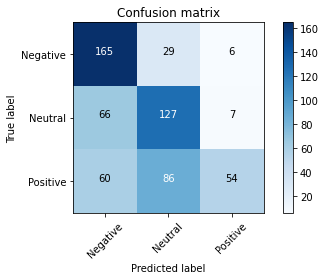

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm_biba = confusion_matrix(balance_y, preds_b)
plt.figure()
plot_confusion_matrix(cm_biba, classes = ["Negative", "Neutral", "Positive"])
plt.savefig("/content/MyDrive/MyDrive/bert_balance.png")